In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
path = '/content/drive/My Drive/bt4222code'

In [50]:
X_train = pd.read_csv(path + '/training_set.csv')
X_train.head()

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment
0,20,1487,8,-0.028291,37,11,5,1,122.714286,1.384051,103.900061,0.333809,1,0.056981
1,21,668,6,0.130119,40,1,8,0,-1.000000,1.358962,103.763673,-0.261162,2,0.145982
2,23,291,3,-0.030116,24,1,11,0,169.428571,1.383134,103.744511,-0.092774,1,0.073223
3,18,1734,4,-0.028981,26,4,14,0,163.857143,1.355347,103.960666,0.109292,1,0.052676
4,20,1932,4,-0.029067,37,11,5,0,122.714286,1.446986,103.799769,0.075614,1,0.083862


In [51]:
y_train = pd.read_csv(path + '/training_labels.csv')
y_train.head()

,price
0,-0.268334
1,0.137525
2,-0.392790
3,-0.319220
4,-0.322286


In [52]:
X_test = pd.read_csv(path + '/testing_set.csv')
X_test.head()

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment
0,27,1972,9,-0.026896,18,2,19,0,64.000000,1.425057,103.844262,-0.025418,2,0.071470
1,27,1988,2,-0.030849,18,2,19,0,64.000000,1.428767,103.832604,-0.407098,1,0.071470
2,20,141,4,-0.025876,37,11,5,0,122.714286,1.348742,103.711118,-0.025418,1,0.064371
3,19,1452,9,-0.026809,45,5,16,0,202.142857,1.401083,103.898665,-0.115225,3,0.083045
4,3,351,6,-0.026451,24,16,7,0,193.285714,1.303114,103.797330,-0.811229,2,0.091372


In [53]:
y_test = pd.read_csv(path + '/testing_labels.csv')
y_test.head()

,price
0,0.014909
1,-0.415542
2,-0.291631
3,0.091544
4,-0.086249


In [ ]:
# built stacking ensemble

# Built level 0 

def get_all_base_model_corr(X_train, y_train):
  base_models = dict()
  base_models['knn'] = KNeighborsRegressor()
  base_models['lr'] = LinearRegression()
  base_models['cart'] = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=800, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
  base_models['rf'] = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
  base_models['lgbm'] = LGBMRegressor(random_state=42)
  n_df = y_train
  for name, model1 in base_models.items():
    model1.fit(X_train, y_train)
    df = pd.DataFrame(model1.predict(X_train), columns=[name])
    n_df = pd.concat([n_df, df], axis=1)
  return n_df.corr(), base_models

model_corr, models_dict = get_all_base_model_corr(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
model_corr

,price,knn,lr,cart,rf,lgbm
price,1.000000,0.943162,0.880519,0.982172,0.994735,0.974082
knn,0.943162,1.000000,0.866228,0.944400,0.956680,0.954843
lr,0.880519,0.866228,1.000000,0.892835,0.898771,0.901334
cart,0.982172,0.944400,0.892835,1.000000,0.988172,0.977626
rf,0.994735,0.956680,0.898771,0.988172,1.000000,0.985000
lgbm,0.974082,0.954843,0.901334,0.977626,0.985000,1.000000


In [ ]:
# CART,RF and LGBM are all tree based and are v correlated, drop LGBM, use CART as Level1 Regressor

In [ ]:
# get a stacking ensemble of models
def stacking_regressor(base_models, level0_list, level1):
  level0 = list()
  new_base_models = dict()
  for model in level0_list:
    level0.append((model, base_models[model]))
    new_base_models[model] = base_models[model]
  level1 = base_models[level1]
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  new_base_models['stacking'] = model
  return model, new_base_models

sr, models_dict = stacking_regressor(models_dict, level0_list=['knn','lr', 'cart'], level1='rf')

In [ ]:
models_dict

{'cart': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=800,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best'),
 'knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'lr': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('knn',
                                KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                          

>knn -0.212 (0.104)
>lr -0.226 (0.062)
>cart -0.123 (0.077)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


>stacking -0.098 (0.063)


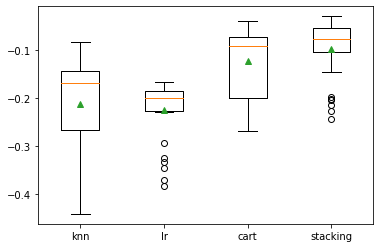

In [ ]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

results, names = list(), list()
for name, model in models_dict.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Metrics for Ensemble

In [ ]:
# Convert both y_train and y_test back to series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

sr.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('cart',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_featu

In [ ]:
# Compute MSE
def mse(y_predicted, y_true):
  return np.mean(np.square(y_predicted - y_true))

mse_training = mse(sr.predict(X_train), y_train)
mse_testing = mse(sr.predict(X_test), y_test)

print("training mse: {}, testing mse: {}".format(mse_training, mse_testing))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(mse_training), np.sqrt(mse_testing)))

training mse: 0.042527784296762565, testing mse: 0.06358416096421753
training rmse: 0.2062226570887946, testing rmse: 0.25215899937185965


In [ ]:

# Compute R2 and adjusted R2
print("training R2: {}, testing R2: {}".format(sr.score(X_train, y_train), sr.score(X_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(
    1 - (1-sr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1), 
    1 - (1-sr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)))

training R2: 0.9574718593599956, testing R2: 0.9292466513827196
training adjusted R2: 0.9574668699275014, testing adjusted R2: 0.9291718705522317


In [ ]:
# Calculate MAE
print("training MAE: {}, testing MAE: {}".format(
    mean_absolute_error(y_train, sr.predict(X_train)),
    mean_absolute_error(y_test, sr.predict(X_test)),    
))

training MAE: 0.04520021746472263, testing MAE: 0.057140342081166536
